# Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from model import Model_3
%matplotlib inline

# Initialize train and test transforms

In [2]:
# Training transform
                                    # Randomly crop image from center. Try different parameters [22, 24, 26]
train_transforms = transforms.Compose([transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
                                       transforms.Resize((28, 28)),
                                       # Apply random ratation on image. Try different parameters [7, 10, 15]
                                       transforms.RandomRotation((-15., 15.), fill=0),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))])

# Test transform
test_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))])

# Download data

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Create data loader

In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Plot data

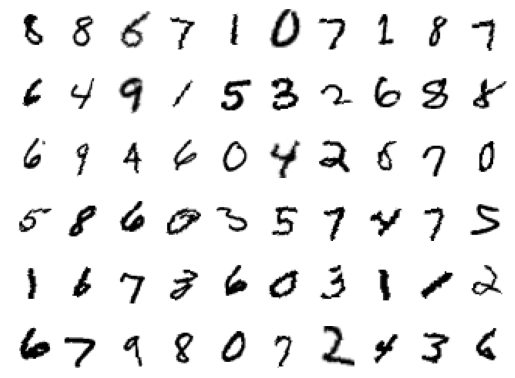

In [5]:
figure = plt.figure()
num_of_images = 60
images, labels = next(iter(train_loader))
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Model_3().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             900
              ReLU-6           [-1, 10, 24, 24]               0
       BatchNorm2d-7           [-1, 10, 24, 24]              20
           Dropout-8           [-1, 10, 24, 24]               0
            Conv2d-9           [-1, 20, 22, 22]           1,800
             ReLU-10           [-1, 20, 22, 22]               0
      BatchNorm2d-11           [-1, 20, 22, 22]              40
          Dropout-12           [-1, 20, 22, 22]               0
           Conv2d-13            [-1, 5, 22, 22]             100
        MaxPool2d-14            [-

In [7]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [8]:
model =  Model_3().to(device)
# Try different lr [0.01, 0.02, 0.04, 0.05, 0.1]
optimizer = optim.SGD(model.parameters(), lr=0.04, momentum=0.9)
# Try different step size [5, 6, 7]
scheduler = StepLR(optimizer, step_size=7, gamma=0.1, verbose=True)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


EPOCH: 0


Loss=0.16202442348003387 Batch_id=468 Accuracy=90.72: 100%|██████████| 469/469 [00:31<00:00, 14.86it/s]



Test set: Average loss: 0.0535, Accuracy: 9838/10000 (98.38%)

EPOCH: 1


Loss=0.11226590722799301 Batch_id=468 Accuracy=97.03: 100%|██████████| 469/469 [00:24<00:00, 19.40it/s]



Test set: Average loss: 0.0422, Accuracy: 9868/10000 (98.68%)

EPOCH: 2


Loss=0.062285784631967545 Batch_id=468 Accuracy=97.36: 100%|██████████| 469/469 [00:23<00:00, 19.81it/s]



Test set: Average loss: 0.0366, Accuracy: 9882/10000 (98.82%)

EPOCH: 3


Loss=0.03658873960375786 Batch_id=468 Accuracy=97.79: 100%|██████████| 469/469 [00:23<00:00, 19.80it/s]



Test set: Average loss: 0.0379, Accuracy: 9883/10000 (98.83%)

EPOCH: 4


Loss=0.046096086502075195 Batch_id=468 Accuracy=97.93: 100%|██████████| 469/469 [00:24<00:00, 19.05it/s]



Test set: Average loss: 0.0305, Accuracy: 9900/10000 (99.00%)

EPOCH: 5


Loss=0.14185740053653717 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:24<00:00, 18.89it/s]



Test set: Average loss: 0.0278, Accuracy: 9915/10000 (99.15%)

EPOCH: 6


Loss=0.08345693349838257 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:23<00:00, 19.71it/s]



Test set: Average loss: 0.0249, Accuracy: 9923/10000 (99.23%)

EPOCH: 7


Loss=0.022941777482628822 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:24<00:00, 19.52it/s]



Test set: Average loss: 0.0210, Accuracy: 9935/10000 (99.35%)

EPOCH: 8


Loss=0.01244110707193613 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:23<00:00, 19.83it/s]



Test set: Average loss: 0.0200, Accuracy: 9941/10000 (99.41%)

EPOCH: 9


Loss=0.025719081982970238 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:23<00:00, 19.88it/s]



Test set: Average loss: 0.0194, Accuracy: 9940/10000 (99.40%)

EPOCH: 10


Loss=0.04516643285751343 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:23<00:00, 19.93it/s]



Test set: Average loss: 0.0191, Accuracy: 9945/10000 (99.45%)

EPOCH: 11


Loss=0.02320101298391819 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:23<00:00, 19.72it/s]



Test set: Average loss: 0.0196, Accuracy: 9937/10000 (99.37%)

EPOCH: 12


Loss=0.039545491337776184 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:24<00:00, 19.44it/s]



Test set: Average loss: 0.0198, Accuracy: 9939/10000 (99.39%)

EPOCH: 13


Loss=0.02832990698516369 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:24<00:00, 19.31it/s]



Test set: Average loss: 0.0189, Accuracy: 9942/10000 (99.42%)

EPOCH: 14


Loss=0.06188886985182762 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:23<00:00, 19.88it/s]



Test set: Average loss: 0.0191, Accuracy: 9944/10000 (99.44%)



## Target:
1. Add image augmentation
2. Try different learning rate and step size in scheduler

## Results:
1. Parameters: 7760
2. Best train accuracy: 98.65
3. Best test accuracy: 99.45

## Analysis:
1. This model achieved 99.45 accuracy on test data in 15 epochs.
2. Model statisfies all criterion required for this assignment.
3. Using grid search for LR and step_size might be a good idea.